# OR610_001|Deep Learning Project
Authors: Omid Beheshti(G:01066623),  Youssef Faragalla, Elham Jafarghomi

# Motivation of the Project
Arabic handwritten characters recognition has been a consistent challenge in the field of computer vision due to the variation in different indivisual handwriting. In addition, the handwriting of each indivisual can be different to some extent each time.
Previous iterations of this work has included the use of support vector machines [2] , but now has transitioned to the 
use of artificial neural networks to challenge this task. Recent studies have shown the promise with these networks, with studies showing the use of a convolutional neural network [1]–[4] . We would like to reproduce this work with the aim of showing the difference in activation function for simple networks in this recognition task, and creating a convolutional neural network specifically for Arabic letter recognition.

## Overview
In this deep learning project we are trying to use supervised method and train several neural network classifiers
with the goal of achieving above 95% accuracy. We first tried to train several fully connected Neural Network with
different activation functions including Sigmoid, Relu and Tanh in hope of reducing errors and obtaining
higher accuracy.
Since the accuracies resulted from first three models (two layers fully connected with 500 nodes on each layer) were not satisfying,we then trained a basic Convolutional Neural Network and we could achieve 95.6%  accuracy on the test dataset. Afterwards, we tried a full VGG network on the data which resluted in a remarkably low accuracy. this can be becasue of the high number of layers and relatively small size of the prictures, becasue in the researches, the VGG model, that we used,mostly has been used for relative big pictures.Hence, we developed a minimized VGG model which resulted in an acceptable accuracy (0.94). Finally, we tried another VGG model including a dropout layer which resulted in 0.96 accuracy.  

# Related work

A project has been done on arabic handwritten letters by Najwa Altwaijry published on June,2020.In that project, there were 591 participants including children aged between 7-12. They trained the model on both Hijja and Arabic Handwritten Character Dataset(AHCD),for which they have had accurasy of 88% and 97% perecent, respectively. their model is including 5 convolutional, 3 maxpooling and 3 fully connected layers with softmax output layer. 

https://link.springer.com/article/10.1007/s00521-020-05070-8

## Import required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from IPython.display import clear_output
from sklearn.utils.class_weight import compute_class_weight
# Import required libraries for reading image and processing it
import csv
import scipy
from scipy import ndimage

## Dataset
The dataset for this project is called “The Arabic Handwritten Characters Dataset”, downloaded from “Kaggle”.
The dataset contains 16,800 labeled grayscale images of characters of "32X32",written by 60 participants from 
different age, all in the form  of CSV file. Each character (from “alef” to “yeh”) is written ten times and in 
two different forms, by each participant. Each training and test dataset have total of 1025 columns. From this 
1025 columns, one column contains the class labels (total of 28 classes) and 1024 columns contain pixel-values of 
each associated character image. 


## Prepare the Train dataset 
Read the train data from CSV and convert the csv pixel values to tensor in PyTorch

In [8]:
#Reading the train pixel values and and train labels from CSV files
with open("trainim.csv","r") as trainim:
    trainim = csv.reader(trainim,delimiter = ",")
    x = []                #initialize a list for storing the train x values 
    for i in trainim:
        x.append(i)
x_train = np.array(x,dtype = np.float32)
x_train = torch.from_numpy(x_train)
mean_x_t = torch.mean(x_train,dim = 0)    
std_x_t = torch.std(x_train, dim = 0)

with open("trainlabel.csv","r") as trainlabel:
    trainlabel = csv.reader(trainlabel,delimiter = ",")
    y = []                #initialize a list for storing the train y values (labels)
    for i in trainlabel:
        y.append(i)
y_train = np.array(y, dtype = np.float32)
y_train = torch.from_numpy(y_train)
mean_y_t = torch.mean(y_train, dim = 0)
std_y_t = torch.std(y_train, dim = 0)

train = []               
for i,j in zip(x_train,y_train):
    lst = [i,j]
    train.append(lst)
# train = np.array(train,dtype = np.float32)
# train = torch.FloatTensor(train)
trainloader = torch.utils.data.DataLoader(train,batch_size = 32,shuffle = True)

## Visualize some random images from the train set
Here we create 4 plots in 2x2 shape and display 4 random images of arabic characters

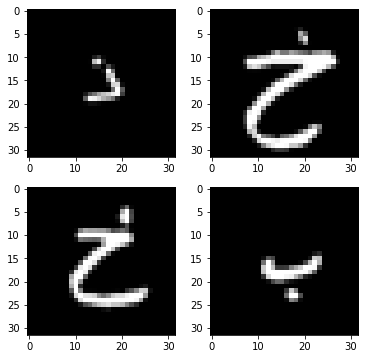

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

plt.figure(figsize=[6, 6])

for i in range(4):
    sample= random.randint(0, x_train.shape[0])
    sample_image = x_train[sample]
    sample_image = sample_image.reshape([32, 32])
    rotate_sample = ndimage.rotate(sample_image,-90)
    flip_sample = np.fliplr(rotate_sample)
    plt.subplot(2, 2,i+1)
    plt.imshow(flip_sample, cmap='gray')

# Prepare the test dataset
Read the test data from CSV and convert from numpy array to tensor in PyTorch

In [10]:
#Reading the test pixel values and and test labels from CSV files
with open("testim.csv","r") as testim:
    testim = csv.reader(testim,delimiter = ",")
    x = []
    for i in testim:
        x.append(i)
x_test = np.array(x,dtype = np.float32)
x_test = torch.from_numpy(x_test)
mean_x_te = torch.mean(x_test,dim = 0)    
std_x_te = torch.std(x_test, dim = 0)

with open("testlabel.csv","r") as testlabel:
    testlabel = csv.reader(testlabel,delimiter = ",")
    y = []
    for i in testlabel:
        y.append(i)
y_test = np.array(y, dtype = np.float32)
y_test = torch.from_numpy(y_test)
mean_y_te = torch.mean(y_test, dim = 0)
std_y_te = torch.std(y_test, dim = 0)

test = []
for i,j in zip(x_test,y_test):
    lst = [i,j]
    test.append(lst)
# train = np.array(train,dtype = np.float32)
# train = torch.FloatTensor(train)
testloader = torch.utils.data.DataLoader(test,batch_size = 32,shuffle = True)

# Fully Connected Deep Neural Network
In this section, we are going to build three fully connected neural network, using different activation functions. 
For each model, we used Adam optimizer because of the efficiency of this optimization technique. 

# FC-NN model architecture incorporating sigmoid activation function with 2 layers.

In [ ]:
class fc_net(nn.Module):
    def __init__(self,input_ch,output_ch,net_depth, hidden_size,act_func):
        super(fc_net,self).__init__()
        self.depth = net_depth
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.hidden_size = hidden_size
        self.layer_list = []
#         print(self.depth)
        for i in range(self.depth):
            if i != net_depth-1:
                if i == 0:
                    self.layer_list.append(nn.Linear(in_features = 1024, out_features = self.hidden_size ))
                else:
                    self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.hidden_size ))
            else:
                self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.output_ch ))

        self.net = nn.Sequential(*self.layer_list)
        print(self.net)
    def forward(self,x):  
        for i in range(self.depth):
#             print(self.net[i])
            linear = self.net[i]
            x = torch.sigmoid(linear(x))
        sftmax = nn.Softmax()
        x = sftmax(x)
        return x
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0],-1)      

## Train the model using Sigmoid activation function and net depth of 2

In [7]:
model = fc_net(input_ch=1024,output_ch=28,net_depth=2,hidden_size=500,act_func="sigmoid")

Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): Linear(in_features=500, out_features=28, bias=True)
)


In [8]:
batch_size = 32
def train_epoch(model, optimizer, batchsize=batch_size):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(trainloader):
        data = x_batch/100
        target = y_batch
        optimizer.zero_grad()
        output = model(data)
        target = target.long().reshape(32)
        target = target - 1
        pred = torch.max(output,1)[1]
        correct = (pred == target.data).sum().item()
        total = len(target.data)
        acc = (correct/total)
        acc_log.append(acc)  
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log 

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(testloader):    
        data = x_batch/100
        target = y_batch
        target = target.long().reshape(32)
        target = target - 1
        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output,dim = 1)[1]
        correct = (pred == target.data).sum().item()
        total = len(target.data)
        acc = (correct/total)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=32)
        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = y_train.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy') 
        print("Epoch: {2}, val loss: {0}, val accuracy: {1},train_acc:{3}".format(np.mean(val_loss), np.mean(val_acc), epoch,np.mean(train_acc_log)))
    return val_log,val_acc_log

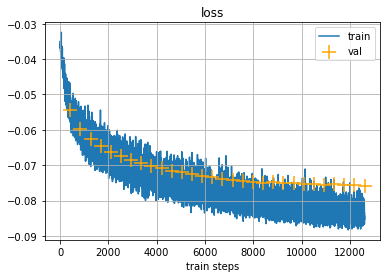

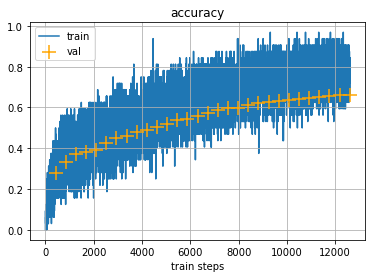

Epoch: 29, val loss: -0.07577450431528546, val accuracy: 0.6622023809523809,train_acc:0.5978025793650794


In [9]:
#Here we used Adam optimizer 

opt = torch.optim.Adam(model.parameters(),lr = 0.0005)
loss_log,acc_log = train(model,opt = opt,n_epochs=30)


The accuracy obtained from using sigmoid activation function is 0.66% on test data, which is not promissing. 

# FC-NN model architecture incorporating ReLU activation function with 2 layers.

In [ ]:
class fc_net1(nn.Module):
    def __init__(self,input_ch,output_ch,net_depth, hidden_size,act_func):
        super(fc_net1,self).__init__()
        self.depth = net_depth
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.hidden_size = hidden_size
        self.layer_list = []
        for i in range(self.depth):
            if i != net_depth-1:
                if i == 0:
                    self.layer_list.append(nn.Linear(in_features = 1024, out_features = self.hidden_size ))
                else:
                    self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.hidden_size ))
            else:
                self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.output_ch ))

        self.net = nn.Sequential(*self.layer_list)
        print(self.net)
    def forward(self,x):  
        for i in range(self.depth):
            linear = self.net[i]
            x = F.relu(linear(x))
        sftmax = nn.Softmax()
        x = sftmax(x)
        return x
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0],-1)

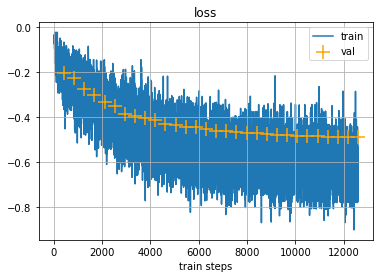

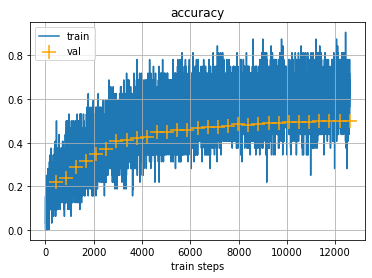

Epoch: 29, val loss: -0.48877808167820885, val accuracy: 0.5014880952380952,train_acc:0.503531746031746


In [14]:
model = fc_net1(input_ch=1024,output_ch=28,net_depth=2,hidden_size=500,act_func="relu")
opt1 = torch.optim.Adam(model.parameters(),lr = 0.0005)
loss_log,acc_log = train(model,opt = opt1,n_epochs=30)

The accuracy obtained from using relu activation function, is lower from the one obtained from using sigmoid
and it is 0.50% on test data. We are going to train another fully connected network using tanh activation 
function in the next section.

# FC-NN model architecture incorporating Tanh activation function with 2 layers.

In [17]:
class fc_net2(nn.Module):
    def __init__(self,input_ch,output_ch,net_depth, hidden_size,act_func):
        super(fc_net2,self).__init__()
        self.depth = net_depth
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.hidden_size = hidden_size
        self.layer_list = []
#         print(self.depth)
        for i in range(self.depth):
            if i != net_depth-1:
                if i == 0:
                    self.layer_list.append(nn.Linear(in_features = 1024, out_features = self.hidden_size ))
                else:
                    self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.hidden_size ))
            else:
                self.layer_list.append(nn.Linear(in_features = self.hidden_size, out_features = self.output_ch ))

        self.net = nn.Sequential(*self.layer_list)
        print(self.net)
    def forward(self,x):  
        for i in range(self.depth):
#             print(self.net[i])
            linear = self.net[i]
            x = F.tanh(linear(x))
        sftmax = nn.Softmax()
        x = sftmax(x)
        return x
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0],-1)      

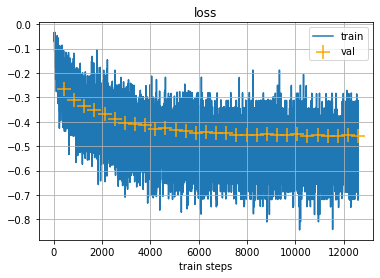

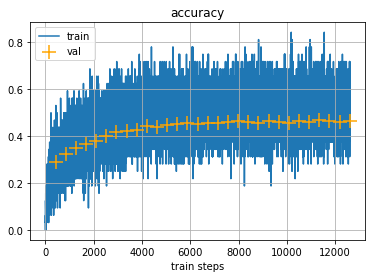

Epoch: 29, val loss: -0.4563091408638727, val accuracy: 0.46279761904761907,train_acc:0.4707589285714286


In [18]:
model = fc_net1(input_ch=1024,output_ch=28,net_depth=2,hidden_size=500,act_func="tanh")
opt = torch.optim.Adam(model.parameters(),lr = 0.0005)
loss_log,acc_log = train(model,opt = opt,n_epochs=30)

The accuracy obtained from using tanh activation function, is lower than all two previous models and is only 0.47% on test data. 
Since we could not get a good performance from fully connected models, we will try to build and train a CNN network in the following section.

## Basic Convolutional Neural Network
In this section we are proposing a model based on convolutional neural network. in this network, there are 3 convolutional layer  which each layer follows a max pooling layer. the depth of the network can be changed to any number based on the user's preferences. 

# CNN model architecture

In [47]:
class Convnet(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, depth,hidden_size,num_classes):
        super().__init__()
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.kernel_size = kernel_size
        self.depth = depth
        self.num_filters = hidden_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        conv_lists = []
        for i in range(self.depth):
            if i != self.depth-1:
                if i == 0:
                    conv_lists.append(nn.Conv2d(in_channels = 1,out_channels = self.num_filters,kernel_size = self.kernel_size,padding= 2))
                    self.num_filters = self.num_filters*2
                else:
                    conv_lists.append(nn.Conv2d(in_channels = self.num_filters//2,out_channels = self.num_filters,kernel_size = self.kernel_size,padding= 2))
                    self.num_filters = self.num_filters*2
            else:
                conv_lists.append(nn.Conv2d(in_channels = self.num_filters//2,out_channels = self.num_filters,kernel_size = self.kernel_size,padding= 2))
                conv_lists.append(nn.Flatten())
        self.network = nn.Sequential(*conv_lists)
        self.size = 32
        for i in range(self.depth):
            new_size = self.size//2
            self.size = new_size
        self.fc1 = nn.Linear(in_features = self.num_filters*self.size*self.size, out_features=self.num_classes)
        self.relu = nn.ReLU()
        self.max = nn.MaxPool2d(2,2)
    def forward(self,x):
        for i in range(self.depth):
            conv = self.network[i]
            x = self.max(self.relu(conv(x)))
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = self.fc1(x)
        return x


In [48]:
from collections import defaultdict
def train_epoch(model, optimizer, trainloader):
    loss_log = []
    model.train()
    train_acc = []
    for _, (x_batch, y_batch) in zip(range(len(trainloader)), trainloader):
        data = x_batch
        data = data.view(32,1,32,32)
        target = y_batch
        target = target - 1
        target = target.long().reshape(32)
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output,1)[1] 
        correct = (pred == target).sum().item()
        total = len(target)
        acc = correct/total
        train_acc.append(acc)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    return loss_log,train_acc

def test(model, test_loader, train_loader):
    '''
        Computes metrics on both train and test, loss on test
    '''
    history = defaultdict(list)
    model.eval()
    test_acc_log = []
    test_loss_log = []
    for batch_num, (x_batch, y_batch) in zip(range(len(test_loader)), test_loader):
        data = x_batch
        data = data.view(32,1,32,32)
        target = y_batch
        target = target.long().reshape(32)
        target = target - 1
        output = model(data)
        pred = torch.max(output, 1)[1] 
        ce_loss = nn.CrossEntropyLoss()(output, target.squeeze()).item()
        test_correct = (pred == target).sum().item()
        total = len(target)
        test_acc = test_correct/total
        test_acc_log.append(test_acc)
        test_loss_log.append(ce_loss)
    history["Test_acc"].append(np.mean(test_acc_log))
    history["Test_Loss"].append((np.mean(test_loss_log)))
    test_acc_log = [np.mean(test_acc_log)]
    test_loss_log = [np.mean(test_loss_log)]
    return test_acc_log,test_loss_log

def plot_history(history):
    fig = plt.figure(figsize=[6,6])
    train = fig.add_subplot(111,label = "Train acc")
    test = fig.add_subplot(111,label = "Test acc",frame_on = False,sharey = train)
    train.plot(range(len(history["Train_acc"])),history["Train_acc"],color = "b",label = "Train acc")
    test.scatter(range(len(history["Test_acc"])),history["Test_acc"],marker = "+",s = 200,color = "r",label = "Val acc")
    test.set_xticks([])
    train.legend(labels = ["Train acc"],bbox_to_anchor=(0.85,0.86))
    test.legend(labels = ["Val acc"],loc = "best")
    plt.grid()
    plt.show()
    fig1 = plt.figure(figsize=[6,6])
    train1 = fig1.add_subplot(111,label = "Train Loss")
    test1 = fig1.add_subplot(111,label = "Test Loss",frame_on = False,sharey = train1)
    train1.plot(range(len(history["loss_train"])),history["loss_train"],color = "b",label = "Train Loss")
    test1.scatter(range(len(history["Test_loss"])),history["Test_loss"],marker = "+",s = 200,color = "r",label = "Val acc")
    train1.legend(labels = ["Train Loss","Test Loss"], loc = "best")
    test1.legend(labels=["Val Loss"],bbox_to_anchor=(0.87,0.9))
    plt.autoscale(enable=True,axis="x")
    plt.grid()
    plt.show()


    
def train_procedure(model, opt, n_epochs, train_loader, test_loader,scheduler):
    history = defaultdict(list)
    steps = len(train_loader)

    for epoch in range(n_epochs):
        
        train_loss,train_acc = train_epoch(model, opt, train_loader)
        test_acc_log,test_loss_log = test(model, test_loader, train_loader)
        history["loss_train"].extend(train_loss)
        history["Train_acc"].extend(train_acc)
        history["Test_acc"].extend(test_acc_log)
        history["Test_loss"].extend(test_loss_log)
        acc_history = {"Train":history["Train_acc"],"Test":history["Test_acc"]}
        loss_history = {"Train":history["loss_train"],"Test":history["Test_loss"]}
        clear_output()
        plot_history(history)
        print("Epoch:{0} of {3}, Test acc:{1}, Test_Loss:{2}".format(epoch,history["Test_acc"][-1],history["Test_loss"][-1],n_epochs-1))


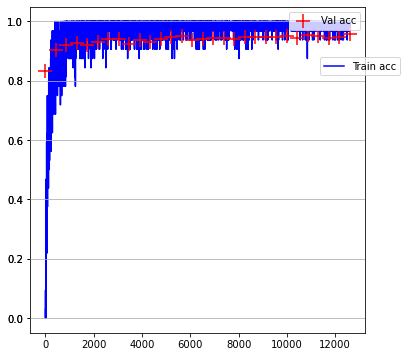

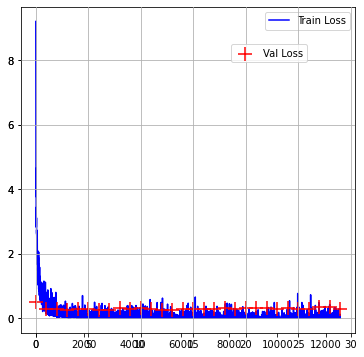

Epoch:29 of 29, Test acc:0.95625, Test_Loss:0.2700952889507053


In [49]:
from torch.optim.lr_scheduler import StepLR
from tqdm import trange
lr_step = 10 
lr_gamma = 0.5
model = Convnet(input_ch=1,output_ch=40,kernel_size=5,depth=3,hidden_size=30,num_classes=28)
opt = torch.optim.Adam(model.parameters(),lr = 3e-4)
scheduler = StepLR(opt, step_size=lr_step, gamma=lr_gamma)
train_procedure(model = model,opt = opt,n_epochs=30,train_loader=trainloader,test_loader=testloader,scheduler=scheduler)

# Full VGG Net
The model has 10 convolutional, 3 fully connected and 4 max pooling layers. 


In [39]:
class full_VGG(torch.nn.Module):
    def __init__(self, input_ch,num_classes):
        super(full_VGG,self).__init__()
        self.num_classes = num_classes
        self.input_ch = input_ch
        self.max = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.input_ch = 64
        self.conv2 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.conv3 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)
        self.input_ch = 128
        self.conv4 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)
        
        self.conv5 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.input_ch = 256
        self.conv6 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.conv7 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        
        self.conv8 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.input_ch = 512
        self.conv9 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.conv10 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.fc1 = nn.Linear(in_features=2048,out_features=1048)
        self.fc2 = nn.Linear(in_features=1048,out_features=1048)
        self.fc3 = nn.Linear(in_features=1048,out_features=self.num_classes)
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.max(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max(x) #8
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.max(x) #4
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.max(x) #2
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Minimized VGG model
this model has 4 convolutional, 4 max pooling  and 2 fully coonected layers.

In [14]:
class mini_VGG(torch.nn.Module):
    def __init__(self, input_ch,num_classes):
        super(mini_VGG,self).__init__()
        self.num_classes = num_classes
        self.input_ch = input_ch
        self.max = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.input_ch = 64
        self.conv2 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.conv3 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)
        self.input_ch = 128
        self.conv4 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)
        
        self.conv5 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.input_ch = 256
        self.conv6 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.conv7 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        
        self.conv8 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.input_ch = 512
        self.conv9 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.conv10 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.fc1 = nn.Linear(in_features=2048,out_features=1048)
        self.fc2 = nn.Linear(in_features=1048,out_features=548)
        self.fc3 = nn.Linear(in_features=548,out_features=self.num_classes)
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.max(x)
        x = self.relu(self.conv3(x))
        x = self.max(x) #8
        x = self.relu(self.conv5(x))
        x = self.max(x) #4
        x = self.relu(self.conv8(x))
        x = self.max(x) #2
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
from collections import defaultdict
def train_epoch(model, optimizer, trainloader):
    loss_log = []
    model.train()
    train_acc = []
    for _, (x_batch, y_batch) in zip(range(len(trainloader)), trainloader):
        data = x_batch
        data = data.view(32,1,32,32)
        target = y_batch
        target = target - 1
        target = target.long().reshape(32)
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output,1)[1] 
        correct = (pred == target).sum().item()
        total = len(target)
        acc = correct/total
        train_acc.append(acc)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    return loss_log,train_acc

def test(model, test_loader, train_loader):
    '''
        Computes metrics on both train and test, loss on test
    '''
    history = defaultdict(list)
    model.eval()
    test_acc_log = []
    test_loss_log = []
    for batch_num, (x_batch, y_batch) in zip(range(len(test_loader)), test_loader):
        data = x_batch
        data = data.view(32,1,32,32)
        target = y_batch
        target = target.long().reshape(32)
        target = target - 1
        output = model(data)
        pred = torch.max(output, 1)[1] #before: (bs, classes, h, w)
        ce_loss = nn.CrossEntropyLoss()(output, target.squeeze()).item()
#         ce_loss = F.nll_loss(output, target).cpu()
        test_correct = (pred == target).sum().item()
        total = len(target)
        test_acc = test_correct/total
        test_acc_log.append(test_acc)
        test_loss_log.append(ce_loss)
    history["Test_acc"].append(np.mean(test_acc_log))
    history["Test_Loss"].append((np.mean(test_loss_log)))
    test_acc_log = [np.mean(test_acc_log)]
    test_loss_log = [np.mean(test_loss_log)]
    return test_acc_log,test_loss_log

def plot_history(history):
#     print(history["Test_loss"])
    fig = plt.figure(figsize=[6,6])
    train = fig.add_subplot(111,label = "Train acc")
    test = fig.add_subplot(111,label = "Test acc",frame_on = False,sharey = train)
    train.plot(range(len(history["Train_acc"])),history["Train_acc"],color = "b",label = "Train acc")
    test.scatter(range(len(history["Test_acc"])),history["Test_acc"],marker = "+",s = 200,color = "r",label = "Val acc")
    test.set_xticks([])
    train.legend(labels = ["Train acc"],bbox_to_anchor=(0.85,0.86))
    test.legend(labels = ["Val acc"],loc = "best")
    plt.grid()
    plt.show()
    fig1 = plt.figure(figsize=[6,6])
    train1 = fig1.add_subplot(111,label = "Train Loss")
    test1 = fig1.add_subplot(111,label = "Test Loss",frame_on = False,sharey = train1)
    train1.plot(range(len(history["loss_train"])),history["loss_train"],color = "b",label = "Train Loss")
    test1.scatter(range(len(history["Test_loss"])),history["Test_loss"],marker = "+",s = 200,color = "r",label = "Val acc")
    train1.legend(labels = ["Train Loss","Test Loss"], loc = "best")
    test1.legend(labels=["Val Loss"],bbox_to_anchor=(0.87,0.9))
    plt.autoscale(enable=True,axis="x")
    plt.grid()
    plt.show()


    
def train_procedure(model, opt, n_epochs, train_loader, test_loader):
    history = defaultdict(list)
    steps = len(train_loader)

    for epoch in range(n_epochs):
        train_loss,train_acc = train_epoch(model, opt, train_loader)
        test_acc_log,test_loss_log = test(model, test_loader, train_loader)
        history["loss_train"].extend(train_loss)
        history["Train_acc"].extend(train_acc)
        history["Test_acc"].extend(test_acc_log)
        history["Test_loss"].extend(test_loss_log)
        acc_history = {"Train":history["Train_acc"],"Test":history["Test_acc"]}
        loss_history = {"Train":history["loss_train"],"Test":history["Test_loss"]}
        clear_output()
        plot_history(history)
        print("Epoch:{0} of {3}, Test acc:{1}, Test_Loss:{2}".format(epoch,history["Test_acc"][-1],history["Test_loss"][-1],n_epochs-1))


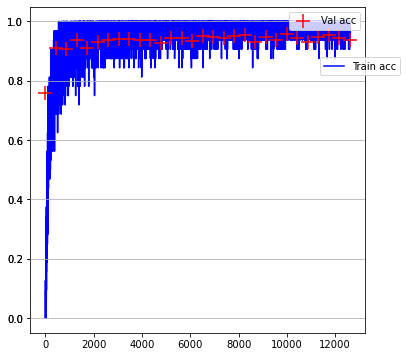

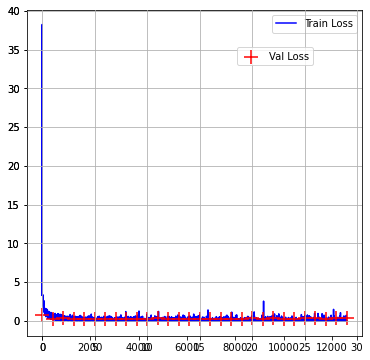

Epoch:29 of 29, Test acc:0.9369047619047619, Test_Loss:0.4170167849959333


In [16]:
mini_vgg_model = mini_VGG(input_ch = 1,num_classes = 28)
opt_vgg = torch.optim.Adam(mini_vgg_model.parameters(),lr = 0.001)
train_procedure(model=mini_vgg_model, opt=opt_vgg, n_epochs = 30, train_loader = trainloader, test_loader = testloader)

In [ ]:
full_VGG_model = full_VGG(input_ch = 1,num_classes = 28)
opt_vgg = torch.optim.Adam(full_VGG_model.parameters(),lr = 0.001)
train_procedure(model=full_VGG_model, opt=opt_vgg, n_epochs = 30, train_loader = trainloader, test_loader = testloader)

# Full VGG with drop out layer

In [12]:
 
        super(drop_out_VGG,self).__init__()
        self.num_classes = num_classes
        self.input_ch = input_ch
        self.max = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.input_ch = 64
        self.conv2 = nn.Conv2d(in_channels = self.input_ch,out_channels = 64,kernel_size = 3,padding= 1)
        self.conv3 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)
        self.input_ch = 128
        self.conv4 = nn.Conv2d(in_channels = self.input_ch,out_channels = 128,kernel_size = 3,padding= 1)

        self.conv5 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.input_ch = 256
        self.conv6 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)
        self.conv7 = nn.Conv2d(in_channels = self.input_ch,out_channels = 256,kernel_size = 3,padding= 1)

        self.conv8 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.input_ch = 512
        self.conv9 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.conv10 = nn.Conv2d(in_channels = self.input_ch,out_channels = 512,kernel_size = 3,padding= 1)
        self.fc1 = nn.Linear(in_features=2048,out_features=1048)
        self.fc2 = nn.Linear(in_features=1048,out_features=1048)
        self.fc3 = nn.Linear(in_features=1048,out_features=self.num_classes)
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = F.dropout(x, training=self.training)
        x = self.max(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = F.dropout(x, training=self.training)
        x = self.max(x) #8
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.max(x) #4
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.max(x) #2
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

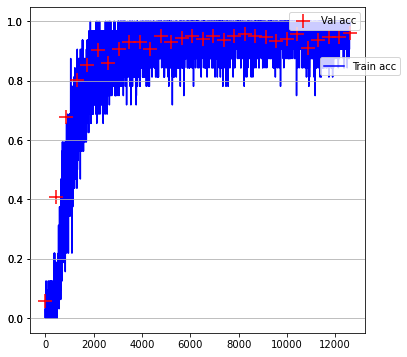

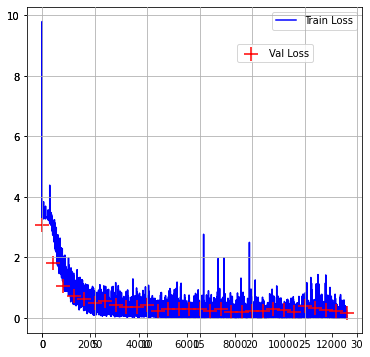

Epoch:29 of 29, Test acc:0.9604166666666667, Test_Loss:0.17928361431473777


In [13]:
dropout_VGG_model = drop_out_VGG(input_ch = 1,num_classes = 28)
opt_vgg = torch.optim.Adam(dropout_VGG_model.parameters(),lr = 0.001)
train_procedure(model=dropout_VGG_model, opt=opt_vgg, n_epochs = 30, train_loader = trainloader, test_loader = testloader)

# Conclusion:
We tried several models from fully connected neural networks to basic convolutional network and different VGG models and we  found that the full VGG with dropout network is the most efficient one with 96.04% accuracy. Compared to the fully connected neural networks, the basic CNN one has significantly higher accuracy(95.62 %), but at the end the full VGG with dropout was our best performing model. 

Overall, this paper shows the viability of using convolutional neural networks in Arabic letter recognition against simple two-layer neural networks as used historically for this task [1] . In simple fully-connected networks, we have found that surprisingly the sigmoid function had a higher accuracy rate for this task compared to the widely used ReLu. 

Our next step is to develop sequenced reading and prediction of the Arabic names, similar to those done in the English language [5] . We expect this problem to be far more computationally expensive and will require Bayesian neural networks. We will also continue our investigation in the choice of activation functions in VGG, including leaky ReLu activation functions. 

# References:
[1]        H. M. Najadat, A. A. Alshboul, and A. F. Alabed, “Arabic Handwritten Characters Recognition using Convolutional Neural Network,” in 2019 10th International Conference on Information and Communication Systems (ICICS), Irbid, Jordan, Jun. 2019, pp. 147–151, doi: 10.1109/IACS.2019.8809122.

[2]        H. M. Balaha, H. A. Ali, and M. Badawy, “Automatic recognition of handwritten Arabic characters: a comprehensive review,” Neural Comput & Applic, Jul. 2020, doi: 10.1007/s00521-020-05137-6.

[3]        Mudhsh, Mohammed Ali and Almodfer, Rolla, “Arabic Handwritten Alphanumeric Character Recognition Using Very Deep Neural Network,” Information, vol. 8, no. 3, p. 105, Aug. 2017, doi: 10.3390/info8030105.

[4]        N. Altwaijry and I. Al-Turaiki, “Arabic handwriting recognition system using convolutional neural network,” Neural Comput & Applic, Jun. 2020, doi: 10.1007/s00521-020-05070-8.

[5]        M. Welling and Y. W. Teh, “Bayesian Learning via Stochastic Gradient Langevin Dynamics,” Proceedings  of  the  28th International  Conference  on  Machine  Learning, p. 8, 2011.
